## Image Segmentation using MONAI & Pytorch
**Monai is a Pytorch-framework**
<br>

We will be creating a **UNet** based architecture

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"shirleykokane16","key":"76340bd48027973651e4f39544c215d4"}') # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

     |████████████████████████████████| 59 kB 5.2 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73275 sha256=69f5ad098f023101aac0806072e480901a12b220108fb84b6870cea746cf4325
  Stored in directory: /root/.cache/pip/wheels/de/f7/d8/c3902cacb7e62cb611b1ad343d7cc07f42f7eb76ae3a52f3d1
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 99% 704M/714M [00:11<00:00, 83.9MB/s]
100% 714M/714M [00:12<00:00, 62.3MB/s]


In [ ]:
!unzip /content/lgg-mri-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_1

# Importing Libraries

In [ ]:
!pip install monai

     |████████████████████████████████| 721 kB 14.6 MB/s 


In [ ]:
import os
import monai
import torch,torchvision
import skimage
import numpy as np 
import pandas as pd 
from glob import glob
import matplotlib.pyplot as plt
from monai.config import print_config
from monai.utils import first
from monai.config import KeysCollection
from monai.data import Dataset, ArrayDataset, create_test_image_3d, DataLoader
from monai.transforms import (
    Compose,
    AddChanneld,
    LoadImaged,
    Spacingd,
    Resized,
    ScaleIntensityRanged,
    CropForegroundd,
    Resized,
    ToTensor,
    ToTensord,
    Orientationd,
    NormalizeIntensityd,
    RandRotated,
    RandAxisFlipd,
    RandFlipd,
    AdjustContrastd,
)
print_config()

MONAI version: 0.8.1
Numpy version: 1.21.6
Pytorch version: 1.11.0+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 71ff399a3ea07aef667b23653620a290364095b1

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.12.0+cu113
tqdm version: 4.64.0
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# Loading The Data



## Understanding the dataset

**We will create two arrays  containing file name of Brain MRI and there respective Masks.** 

In [ ]:
# Mask Files
mask_files = sorted(glob('/content/lgg-mri-segmentation/kaggle_3m/*/*_mask*'))#

In [ ]:
# Brain MRI Images
training_files = []
for path in mask_files:
    training_files.append(path.replace('_mask',''))

# Visualization of data

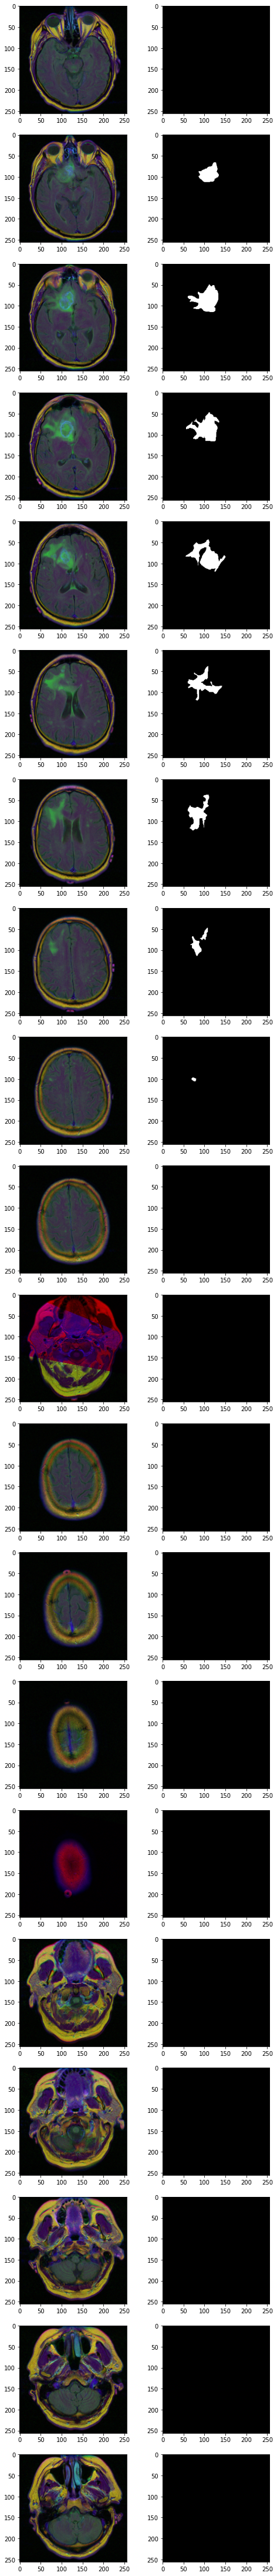

In [ ]:
rows = 20
fig,ax = plt.subplots(rows,2,figsize=(8,80))
for i in range(rows):
    read1 = plt.imread(training_files[i])
    read2 = plt.imread(mask_files[i])
    ax[i,0].imshow(read1)
    ax[i,1].imshow(read2,cmap='gray')
plt.show()

In [ ]:
# will tell us if a image has mask or not
def is_mask(path):
    mask = plt.imread(path)
    if np.max(mask) != 0.0:
        return 1
    else:
        return 0

In [ ]:
df = pd.DataFrame({'training_files':training_files,'mask_files':mask_files})
df['mask'] = df['mask_files'].apply(lambda x: is_mask(x))

In [ ]:
df.head()

training_files  \
0  /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
1  /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
2  /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
3  /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
4  /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...   

                                          mask_files  mask  
0  /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...     0  
1  /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...     1  
2  /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...     1  
3  /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...     1  
4  /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...     1

In [ ]:
df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

So lets reorganize or data to only containe data points with Masks

In [ ]:
data = df[df['mask']==1]

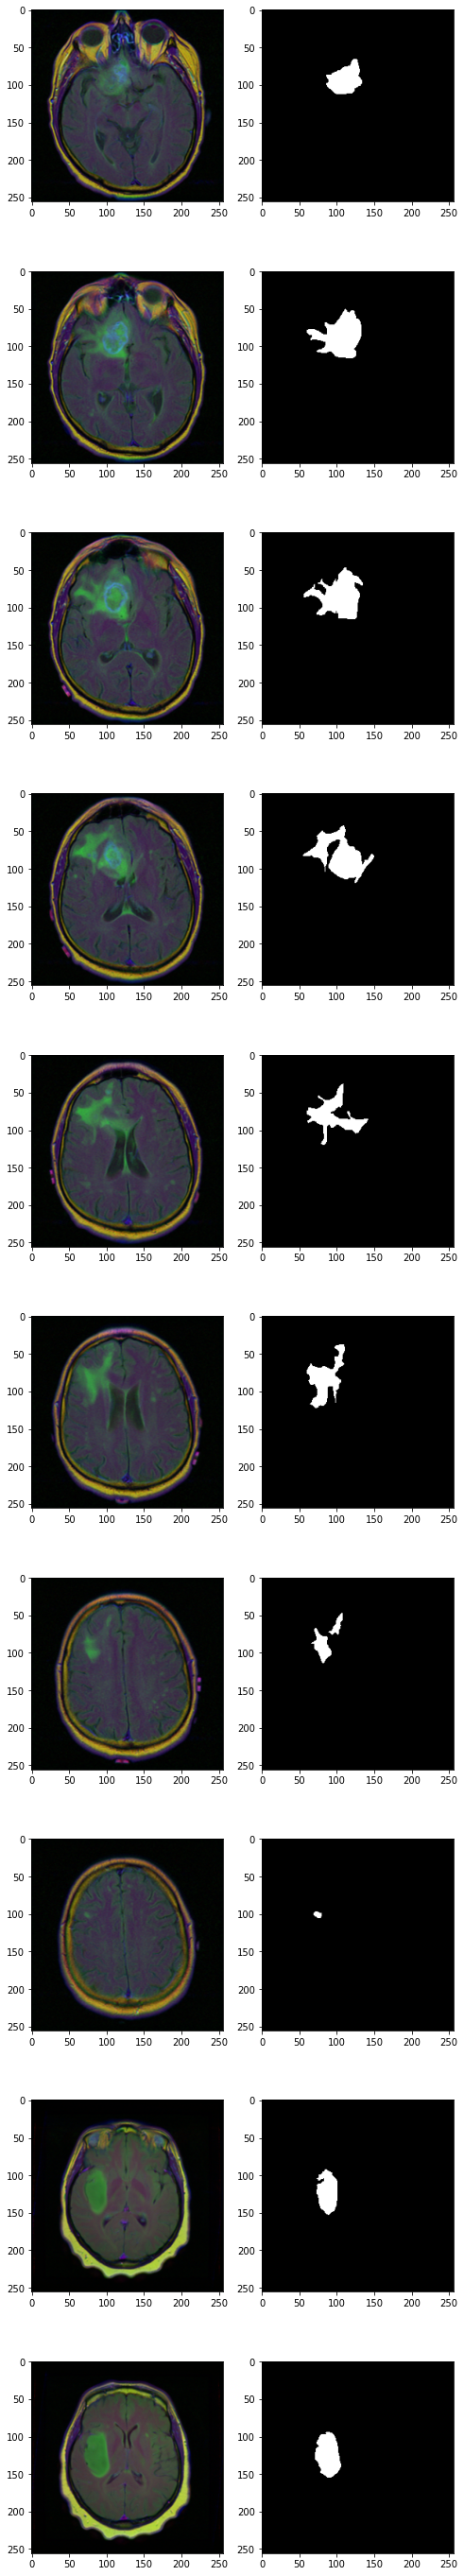

In [ ]:
rows = 10
fig,ax = plt.subplots(rows,2,figsize=(8,50))
for i in range(rows):
    read1 = plt.imread(data['training_files'].iloc[i])
    read2 = plt.imread(data['mask_files'].iloc[i])
    ax[i,0].imshow(read1,cmap='gray')
    ax[i,1].imshow(read2,cmap='gray')
plt.show()

# Data Processing


In [ ]:
# Creating Dir to store the converted files
dir = '/content/new_data'
mask_out_path = '/content/new_data/mask'
input_out_path = '/content/new_data/input'
os.mkdir(dir)
os.mkdir(mask_out_path)
os.mkdir(input_out_path)

In [ ]:
# This library will help in convention
!pip install imio

  Created wheel for configobj: filename=configobj-5.0.6-py3-none-any.whl size=34547 sha256=0e400314cb952c2667b970678352d89615075988ba5fb44db941421466eeb444
  Stored in directory: /root/.cache/pip/wheels/0d/c4/19/13d74440f2a571841db6b6e0a273694327498884dafb9cf978
Successfully built configobj


In [ ]:
from imio import load, save

In [ ]:
# Traning Files
for path in data['training_files']:
    img = plt.imread(path)
    img = skimage.color.rgb2gray(img)
    name = os.path.basename(os.path.normpath(path))
    name = os.path.splitext(name)[0]
    save.to_nii(img, "{}/{}.nii.gz".format(input_out_path,name))

In [ ]:
# Mask Files
for path in data['mask_files']:
    img = plt.imread(path)
    name = os.path.basename(os.path.normpath(path))
    name = os.path.splitext(name)[0]
    save.to_nii(img, "{}/{}.nii.gz".format(mask_out_path,name))

# Preprocessing & Data Augmentation 

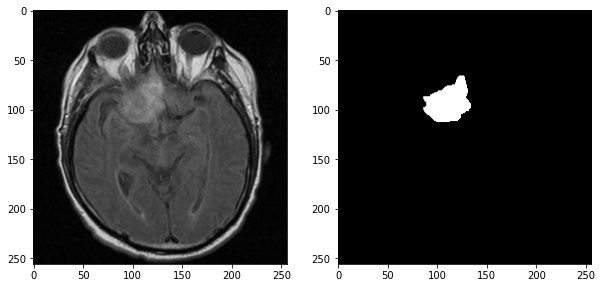

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
img = skimage.color.rgb2gray(plt.imread(data['training_files'].iloc[0]))
mask = plt.imread(data['mask_files'].iloc[0])
ax[0].imshow(img,cmap='gray')
ax[1].imshow(mask,cmap='gray')

In [ ]:
# First we have to get that .nii data
filenames = []
img = sorted(glob('/content/new_data/input/*'))
mask = sorted(glob('/content/new_data/mask/*'))
for i in range(len(img)):
    filenames.append({'img':img[i],'mask':mask[i]})

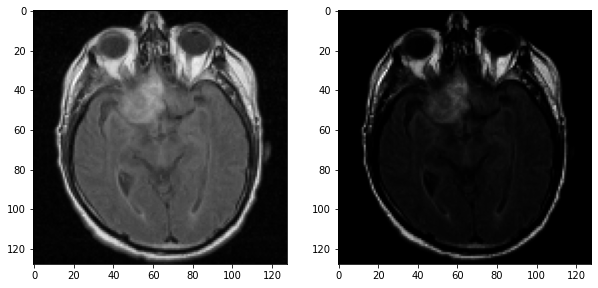

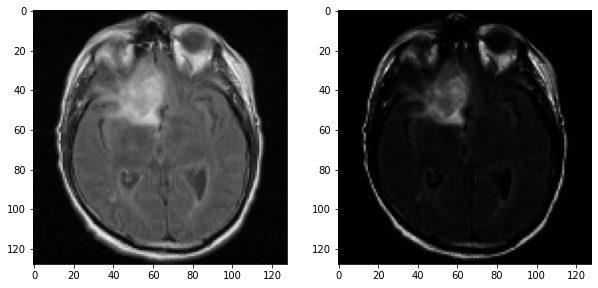

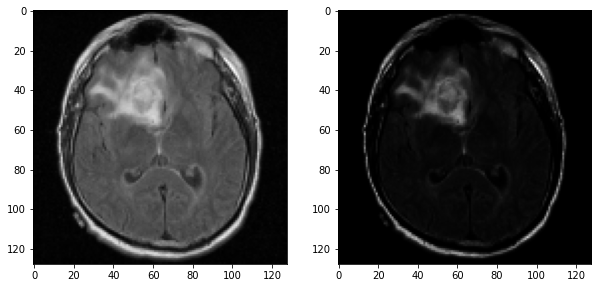

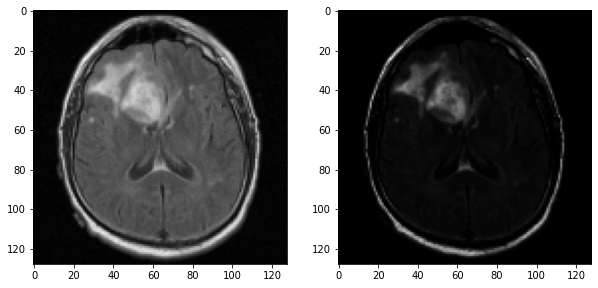

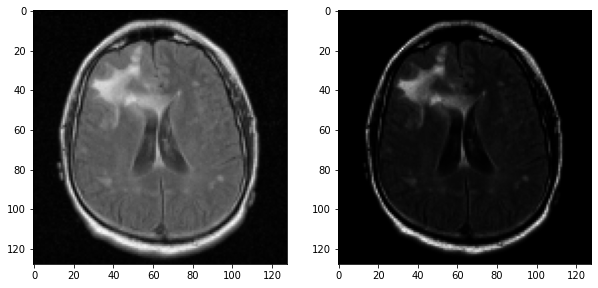

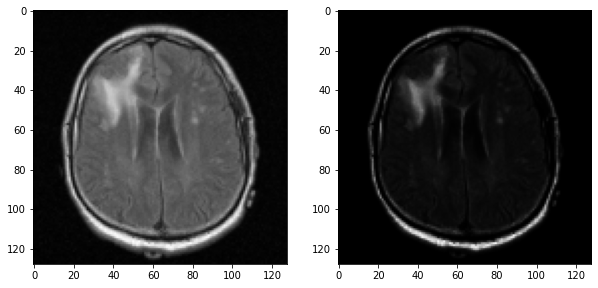

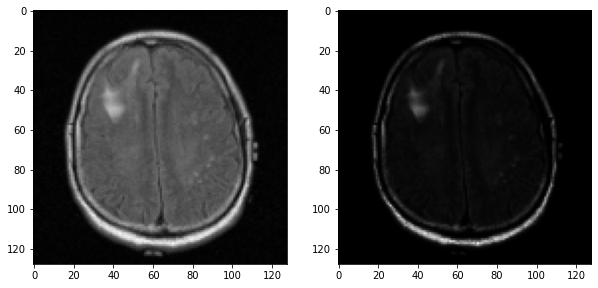

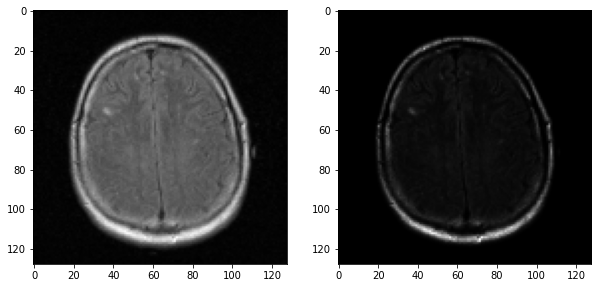

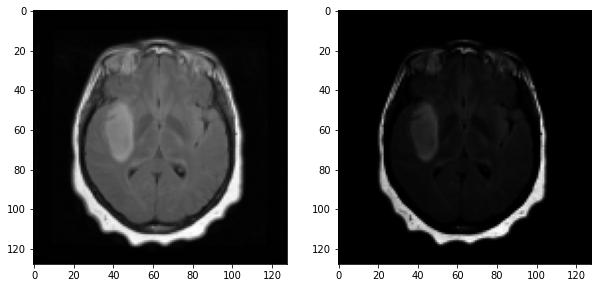

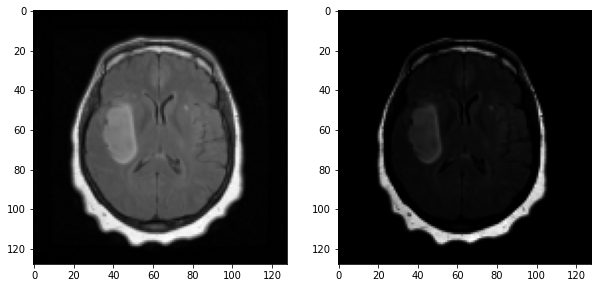

In [ ]:
for i in range(0,10):
  li = LoadImaged(keys=['img','mask'])
  li_img = li(filenames[i])
  li_img['img'].shape
  add = AddChanneld(keys=['img','mask'])
  add_img = add(li_img)
  res = Resized(spatial_size  = (128,128),keys=['img'])
  res_img = res(add_img)
  res_img['img'].shape
  si = AdjustContrastd(keys=["img"],gamma=3)
  si_img = si(res_img)
  fig,ax = plt.subplots(1,2,figsize=(10,5))
  ax[0].imshow(res_img['img'][0,:,:],cmap='gray')
  ax[1].imshow(si_img['img'][0,:,:],cmap='gray')

In [ ]:
org_img = Compose([
    LoadImaged(keys=['img','mask']),
    AddChanneld(keys=['img','mask']),
    Resized(spatial_size  = (128,128),keys=['img','mask']),
    AdjustContrastd(keys="img",gamma=2),
    NormalizeIntensityd(keys=['img','mask'],divisor=255.0,subtrahend=0),
    ToTensor(),
])
preprocess = Compose([
    
    LoadImaged(keys=['img','mask']),
    AddChanneld(keys=['img','mask']),
    Resized(spatial_size  = (128,128),keys=['img','mask']),
    AdjustContrastd(keys="img",gamma=2),
    NormalizeIntensityd(keys=['img','mask'],divisor=255.0,subtrahend=0),
    ToTensor(),  
    
])


In [ ]:
# Preparing the DataSet
train_data = Dataset(data = filenames,transform = preprocess)

In [ ]:
from torch.utils.data import random_split
val = int((len(train_data)/100)*30) # 30%
org = len(train_data)-val
print(val,org)
train_ds,val_ds = random_split(train_data,[org,val])

411 962


In [ ]:
train_loder = DataLoader(train_ds,batch_size = 1)
val_loder = DataLoader(val_ds,batch_size = 1)

# Building the UNet Model

In [ ]:
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F

### Model from Scratch

In [ ]:
class ConvBlock(nn.Module):
    
    def __init__(self,input_ch,output_ch,kernal_size=3):
        super().__init__()
        self.conv1 = nn.Conv2d(input_ch,output_ch,kernal_size)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(output_ch,output_ch,kernal_size)

    def forward(self,x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))
    
class Encoder(nn.Module):
    def __init__(self,layers=[3,64,128,256,512,1024],kernal_size = 3,pool = 2):
        super().__init__()
        self.encoder = nn.ModuleList([ConvBlock(layers[i],layers[i+1],kernal_size) for i in range(len(layers)-1)])
        self.pool_layer = nn.MaxPool2d(pool)

    def forward(self,x):
        encoder = []
        for block in self.encoder:
           
            x = block(x)
            encoder.append(x)
            x = self.pool_layer(x)
        return encoder

class Decoder(nn.Module):
    def __init__(self,layers = [1024,512,256,128,64],kernal_size=3):
        super().__init__()
        self.layers = layers
        self.decoder = nn.ModuleList([ConvBlock(layers[i],layers[i+1],kernal_size) for i in range(len(layers)-1)])
        self.upconv  = nn.ModuleList([nn.ConvTranspose2d(layers[i],layers[i+1],2,2) for i in range(len(layers)-1)])
        
    def forward(self,x,encoder):
        for i in range(len(self.layers)-1):
            x = self.upconv[i](x) 
            connect = self.crop(encoder[i],x)
            x = torch.cat([x,connect],dim=1)
            x = self.decoder[i](x)
        return x
    
    def crop(self,input_tensor,target_tensor):
        _,_,H,W = target_tensor.shape
        reshaped   = torchvision.transforms.CenterCrop([H, W])(input_tensor)
        return reshaped

In [ ]:
class Unet(nn.Module):
    def __init__(self,encoder_layers=[3,64,128,256],decoder_layers = [256,128,64],retain_dimension = True, num_class = 1,outputsize = (128,128) ):
        super().__init__()
        self.encoder = Encoder(encoder_layers)
        self.decoder = Decoder(decoder_layers)
        self.output = nn.Conv2d(decoder_layers[-1],num_class,1)
        self.retain_dimension = retain_dimension
        self.outputsize = outputsize
        
    def forward(self,x):
        enco = self.encoder(x)
        output = self.decoder(enco[::-1][0],enco[::-1][1:])
        output = self.output(output)
        if self.retain_dimension:
            output = F.interpolate(output,self.outputsize)
        return output

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        inputs = torch.sigmoid(inputs)       
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

### Model from Monai

In [ ]:
device='cuda'

In [ ]:
model = monai.networks.nets.UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64,128,256),
        dropout=0.3,
        strides=(2, 2, 2, 2),
        num_res_units=3,
    ).to(device)

In [ ]:
loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

In [ ]:
num_epochs = 40
epoch_loss_values = []
val_loss_values = []

In [ ]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    #y_true = y_true[:,1,:,:]
    y_true = y_true * (y_true>0.9)
    y_pred = y_pred * (y_pred>0.9)
    y_true_f = torch.flatten(y_true)
    y_pred_f = torch.flatten(y_pred)
    # print(y_true_f.size())
    # print(y_true_f.size())
    # print(y_true_f.amax())
    # print(y_true_f.amax())

    intersection = torch.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)
    return score

### Teacher Model Traning

In [ ]:
# Model Traning
#dice_coefficient = []
for epoch in (range(num_epochs)):
        print("-" * num_epochs)
        print(f"epoch {epoch + 1}/{num_epochs}")
        model.train()
        epoch_loss = 0
        avg_val_loss = 0
        step = 0
        print('traning')
        for batch_data in tqdm(train_loder):
            step += 1
            inputs, labels = torch.reshape(batch_data['img'],(1,1,128,128)).to(device), batch_data['mask'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loder.batch_size
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        ii = 0
        for batch in tqdm(val_loder):#val_patient
            ii+=1
            inputs, labels = torch.reshape(batch['img'],(1,1,128,128)).to(device), batch['mask'].to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            #dice_coefficient.append(dice_coeff(labels, outputs))
            avg_val_loss+=loss.item()
        avg_val_loss = avg_val_loss/ii
        val_loss_values.append(avg_val_loss)
       
        
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f} validation_loss: {avg_val_loss:.4f}")

----------------------------------------
epoch 1/40
traning


100%|██████████| 411/411 [00:06<00:00, 63.77it/s]


epoch 1 average loss: 0.8129 validation_loss: 0.6811
----------------------------------------
epoch 2/40
traning


100%|██████████| 411/411 [00:06<00:00, 63.56it/s]


epoch 2 average loss: 0.5685 validation_loss: 0.5139
----------------------------------------
epoch 3/40
traning


100%|██████████| 411/411 [00:06<00:00, 63.26it/s]


epoch 3 average loss: 0.4750 validation_loss: 0.4586
----------------------------------------
epoch 4/40
traning


100%|██████████| 411/411 [00:06<00:00, 63.75it/s]


epoch 4 average loss: 0.4384 validation_loss: 0.4363
----------------------------------------
epoch 5/40
traning


100%|██████████| 411/411 [00:06<00:00, 64.47it/s]


epoch 5 average loss: 0.4223 validation_loss: 0.4148
----------------------------------------
epoch 6/40
traning


100%|██████████| 411/411 [00:06<00:00, 63.00it/s]


epoch 6 average loss: 0.4061 validation_loss: 0.4119
----------------------------------------
epoch 7/40
traning


100%|██████████| 411/411 [00:06<00:00, 62.92it/s]


epoch 7 average loss: 0.4024 validation_loss: 0.4005
----------------------------------------
epoch 8/40
traning


100%|██████████| 411/411 [00:06<00:00, 63.65it/s]


epoch 8 average loss: 0.3830 validation_loss: 0.4055
----------------------------------------
epoch 9/40
traning


100%|██████████| 411/411 [00:06<00:00, 62.93it/s]


epoch 9 average loss: 0.3789 validation_loss: 0.3888
----------------------------------------
epoch 10/40
traning


100%|██████████| 411/411 [00:06<00:00, 62.40it/s]


epoch 10 average loss: 0.3765 validation_loss: 0.3835
----------------------------------------
epoch 11/40
traning


100%|██████████| 411/411 [00:06<00:00, 62.82it/s]


epoch 11 average loss: 0.3765 validation_loss: 0.3806
----------------------------------------
epoch 12/40
traning


100%|██████████| 411/411 [00:06<00:00, 60.32it/s]


epoch 12 average loss: 0.3689 validation_loss: 0.3711
----------------------------------------
epoch 13/40
traning


100%|██████████| 411/411 [00:06<00:00, 64.13it/s]


epoch 13 average loss: 0.3597 validation_loss: 0.3616
----------------------------------------
epoch 14/40
traning


100%|██████████| 411/411 [00:06<00:00, 64.07it/s]


epoch 14 average loss: 0.3567 validation_loss: 0.3612
----------------------------------------
epoch 15/40
traning


100%|██████████| 411/411 [00:06<00:00, 63.91it/s]


epoch 15 average loss: 0.3511 validation_loss: 0.3669
----------------------------------------
epoch 16/40
traning


100%|██████████| 411/411 [00:06<00:00, 64.96it/s]


epoch 16 average loss: 0.3473 validation_loss: 0.3544
----------------------------------------
epoch 17/40
traning


100%|██████████| 411/411 [00:06<00:00, 64.34it/s]


epoch 17 average loss: 0.3442 validation_loss: 0.3634
----------------------------------------
epoch 18/40
traning


100%|██████████| 411/411 [00:06<00:00, 63.44it/s]


epoch 18 average loss: 0.3415 validation_loss: 0.3466
----------------------------------------
epoch 19/40
traning


100%|██████████| 411/411 [00:06<00:00, 64.31it/s]


epoch 19 average loss: 0.3405 validation_loss: 0.3442
----------------------------------------
epoch 20/40
traning


100%|██████████| 411/411 [00:06<00:00, 62.93it/s]


epoch 20 average loss: 0.3360 validation_loss: 0.3536
----------------------------------------
epoch 21/40
traning


100%|██████████| 411/411 [00:06<00:00, 65.07it/s]


epoch 21 average loss: 0.3275 validation_loss: 0.3492
----------------------------------------
epoch 22/40
traning


100%|██████████| 411/411 [00:06<00:00, 64.42it/s]


epoch 22 average loss: 0.3324 validation_loss: 0.3857
----------------------------------------
epoch 23/40
traning


100%|██████████| 411/411 [00:06<00:00, 64.36it/s]


epoch 23 average loss: 0.3258 validation_loss: 0.3353
----------------------------------------
epoch 24/40
traning


100%|██████████| 411/411 [00:06<00:00, 64.27it/s]


epoch 24 average loss: 0.3261 validation_loss: 0.3407
----------------------------------------
epoch 25/40
traning


100%|██████████| 411/411 [00:06<00:00, 64.76it/s]


epoch 25 average loss: 0.3173 validation_loss: 0.3394
----------------------------------------
epoch 26/40
traning


100%|██████████| 411/411 [00:06<00:00, 63.54it/s]


epoch 26 average loss: 0.3158 validation_loss: 0.3301
----------------------------------------
epoch 27/40
traning


100%|██████████| 411/411 [00:06<00:00, 64.50it/s]


epoch 27 average loss: 0.3151 validation_loss: 0.3345
----------------------------------------
epoch 28/40
traning


100%|██████████| 411/411 [00:06<00:00, 60.39it/s]


epoch 28 average loss: 0.3100 validation_loss: 0.3315
----------------------------------------
epoch 29/40
traning


100%|██████████| 411/411 [00:06<00:00, 66.22it/s]


epoch 29 average loss: 0.3184 validation_loss: 0.3279
----------------------------------------
epoch 30/40
traning


100%|██████████| 411/411 [00:06<00:00, 64.09it/s]


epoch 30 average loss: 0.3086 validation_loss: 0.3314
----------------------------------------
epoch 31/40
traning


100%|██████████| 411/411 [00:06<00:00, 64.25it/s]


epoch 31 average loss: 0.3112 validation_loss: 0.3169
----------------------------------------
epoch 32/40
traning


100%|██████████| 411/411 [00:06<00:00, 64.25it/s]


epoch 32 average loss: 0.3104 validation_loss: 0.3469
----------------------------------------
epoch 33/40
traning


100%|██████████| 411/411 [00:06<00:00, 64.15it/s]


epoch 33 average loss: 0.2988 validation_loss: 0.3198
----------------------------------------
epoch 34/40
traning


100%|██████████| 411/411 [00:06<00:00, 64.18it/s]


epoch 34 average loss: 0.3094 validation_loss: 0.3814
----------------------------------------
epoch 35/40
traning


100%|██████████| 411/411 [00:06<00:00, 64.40it/s]


epoch 35 average loss: 0.3020 validation_loss: 0.3061
----------------------------------------
epoch 36/40
traning


100%|██████████| 411/411 [00:06<00:00, 63.95it/s]


epoch 36 average loss: 0.2923 validation_loss: 0.3114
----------------------------------------
epoch 37/40
traning


100%|██████████| 411/411 [00:06<00:00, 64.72it/s]


epoch 37 average loss: 0.2969 validation_loss: 0.3102
----------------------------------------
epoch 38/40
traning


100%|██████████| 411/411 [00:06<00:00, 65.11it/s]


epoch 38 average loss: 0.2876 validation_loss: 0.3528
----------------------------------------
epoch 39/40
traning


100%|██████████| 411/411 [00:06<00:00, 64.52it/s]


epoch 39 average loss: 0.2929 validation_loss: 0.3057
----------------------------------------
epoch 40/40
traning


100%|██████████| 411/411 [00:06<00:00, 64.60it/s]

epoch 40 average loss: 0.2933 validation_loss: 0.3066


In [ ]:
torch.save(model, '/content/teacher_model.pt')

In [ ]:
dice_coefficient = dice_coeff(labels, outputs)

In [ ]:
#teacher_outputs = model(inputs)
#teacher_outputs.shape
print('Average dice score: ', (dice_coefficient))

Average dice score:  tensor(1.7171, device='cuda:0', grad_fn=<DivBackward0>)


Text(0.5, 1.0, 'Teacher Model lossess')

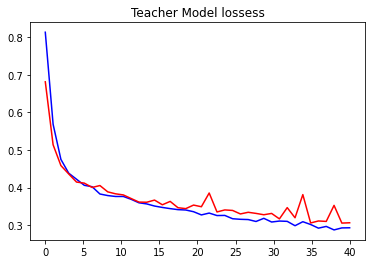

In [ ]:
plt.plot(np.linspace(0,len(epoch_loss_values),len(epoch_loss_values)),epoch_loss_values,color='blue')
plt.plot(np.linspace(0,len(val_loss_values),len(val_loss_values)),val_loss_values,color='red')
plt.title('Teacher Model lossess')

**Transfer** **Learning**

In [ ]:
from torch.autograd import grad

In [ ]:
student_model = monai.networks.nets.UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64),
        dropout=0.3,
        strides=(2, 2),
        num_res_units=3,
    ).to(device)

In [ ]:
def jacobian_distillation(y, teacher_scores,inputs, labels):
    y = torch.reshape(y, (128,128))
    inputs = torch.reshape(inputs, (128,128))
    y.requires_grad_()
    inputs.requires_grad_()
    teacher_scores.requires_grad_()
    #y.requires_grad = True
    y = y + teacher_scores - teacher_scores

    grad_s = grad(outputs= y, inputs= inputs, grad_outputs= [torch.ones_like(y), torch.ones_like(y)], only_inputs=True, create_graph=True, retain_graph=True)[0]
    
    
    norm_grad_s = F.normalize(grad_s.view(grad_s.size(0), -1), p=2, dim=1)

    t = grad(outputs=teacher_scores, inputs= inputs, grad_outputs=[torch.ones_like(
        y), torch.ones_like(y)], only_inputs=True, create_graph=True, retain_graph=True)[0]
    #grad_t = t
    norm_grad_t = F.normalize(grad_t.view(grad_t.size(0), -1), p=2, dim=1)

    mse_loss = (norm_grad_s- norm_grad_t.detach()).pow(2).mean()
    
    loss_function = monai.losses.DiceLoss(sigmoid=True)
    
    #criterion = nn.CrossEntropyLoss(reduction='none')
    l_ce = loss_function(y, labels) 
    l_c = torch.sum(l_ce)/l_ce.size(0)
    loss = l_c + mse_loss
    
    return loss

In [ ]:
def knowledge_distillation(y, teacher_scores,inputs, labels):
    y = torch.reshape(y, (128,128))
    inputs = torch.reshape(inputs, (128,128))
    labels = torch.reshape(labels, (128,128))
    y.requires_grad_()
    inputs.requires_grad_()
    teacher_scores.requires_grad_()
    #y.requires_grad = True
    

    mse_loss = (y- teacher_scores.detach()).pow(2).mean()
    
    loss_function = monai.losses.DiceLoss(sigmoid=True)
    
    #criterion = nn.CrossEntropyLoss(reduction='none')
    l_ce = loss_function(y, labels) 
    #l_c = torch.sum(l_ce)/l_ce.size(0)
    loss = l_ce + mse_loss
    
    return loss

In [ ]:
loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(student_model.parameters(), 1e-3)

for epoch in (range(num_epochs)):
        print("-" * num_epochs)
        print(f"epoch {epoch + 1}/{num_epochs}")
        model.train()
        epoch_loss = 0
        avg_val_loss = 0
        step = 0
        print('traning')
        for batch_data in tqdm(train_loder):
            step += 1
            inputs, labels = torch.reshape(batch_data['img'],(1,1,128,128)).to(device), batch_data['mask'].to(device)
            #optimizer.zero_grad()
            student_model.zero_grad()
            teacher_outputs = model(inputs)
            student_outputs = student_model(inputs)
            
            loss = knowledge_distillation(student_outputs, teacher_outputs,inputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loder.batch_size
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        ii = 0
        for batch in tqdm(val_loder):#val_patient
            ii+=1
            inputs, labels = torch.reshape(batch['img'],(1,1,128,128)).to(device), batch['mask'].to(device)
            outputs = student_model(inputs)
            loss = loss_function(outputs, labels)
            avg_val_loss+=loss.item()
        avg_val_loss = avg_val_loss/ii
        val_loss_values.append(avg_val_loss)
       
        
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f} validation_loss: {avg_val_loss:.4f}")

----------------------------------------
epoch 1/40
traning


100%|██████████| 411/411 [00:05<00:00, 79.78it/s]


epoch 1 average loss: 1787.0218 validation_loss: 0.9160
----------------------------------------
epoch 2/40
traning


100%|██████████| 411/411 [00:05<00:00, 79.22it/s]


epoch 2 average loss: 1067.8897 validation_loss: 0.9445
----------------------------------------
epoch 3/40
traning


100%|██████████| 411/411 [00:05<00:00, 79.36it/s]


epoch 3 average loss: 780.5616 validation_loss: 0.9506
----------------------------------------
epoch 4/40
traning


100%|██████████| 411/411 [00:05<00:00, 79.71it/s]


epoch 4 average loss: 748.6096 validation_loss: 0.9455
----------------------------------------
epoch 5/40
traning


100%|██████████| 411/411 [00:05<00:00, 79.94it/s]


epoch 5 average loss: 735.1118 validation_loss: 0.9529
----------------------------------------
epoch 6/40
traning


100%|██████████| 411/411 [00:05<00:00, 77.23it/s]


epoch 6 average loss: 723.4410 validation_loss: 0.9544
----------------------------------------
epoch 7/40
traning


100%|██████████| 411/411 [00:05<00:00, 74.15it/s]


epoch 7 average loss: 715.8396 validation_loss: 0.9671
----------------------------------------
epoch 8/40
traning


100%|██████████| 411/411 [00:05<00:00, 78.12it/s]


epoch 8 average loss: 716.1664 validation_loss: 0.9609
----------------------------------------
epoch 9/40
traning


100%|██████████| 411/411 [00:05<00:00, 78.55it/s]


epoch 9 average loss: 708.5274 validation_loss: 0.9625
----------------------------------------
epoch 10/40
traning


100%|██████████| 411/411 [00:05<00:00, 80.19it/s]


epoch 10 average loss: 705.5063 validation_loss: 0.9662
----------------------------------------
epoch 11/40
traning


100%|██████████| 411/411 [00:05<00:00, 77.32it/s]


epoch 11 average loss: 704.8749 validation_loss: 0.9672
----------------------------------------
epoch 12/40
traning


100%|██████████| 411/411 [00:05<00:00, 79.24it/s]


epoch 12 average loss: 698.5519 validation_loss: 0.9685
----------------------------------------
epoch 13/40
traning


100%|██████████| 411/411 [00:05<00:00, 77.59it/s]


epoch 13 average loss: 694.4108 validation_loss: 0.9716
----------------------------------------
epoch 14/40
traning


100%|██████████| 411/411 [00:05<00:00, 77.95it/s]


epoch 14 average loss: 692.7753 validation_loss: 0.9695
----------------------------------------
epoch 15/40
traning


100%|██████████| 411/411 [00:05<00:00, 78.46it/s]


epoch 15 average loss: 700.6318 validation_loss: 0.9706
----------------------------------------
epoch 16/40
traning


100%|██████████| 411/411 [00:05<00:00, 78.01it/s]


epoch 16 average loss: 691.8994 validation_loss: 0.9743
----------------------------------------
epoch 17/40
traning


100%|██████████| 411/411 [00:05<00:00, 77.33it/s]


epoch 17 average loss: 694.0333 validation_loss: 0.9736
----------------------------------------
epoch 18/40
traning


100%|██████████| 411/411 [00:05<00:00, 79.47it/s]


epoch 18 average loss: 692.8135 validation_loss: 0.9739
----------------------------------------
epoch 19/40
traning


100%|██████████| 411/411 [00:05<00:00, 79.05it/s]


epoch 19 average loss: 692.7552 validation_loss: 0.9759
----------------------------------------
epoch 20/40
traning


100%|██████████| 411/411 [00:05<00:00, 77.31it/s]


epoch 20 average loss: 695.5966 validation_loss: 0.9751
----------------------------------------
epoch 21/40
traning


100%|██████████| 411/411 [00:05<00:00, 79.49it/s]


epoch 21 average loss: 689.5152 validation_loss: 0.9765
----------------------------------------
epoch 22/40
traning


100%|██████████| 411/411 [00:05<00:00, 80.12it/s]


epoch 22 average loss: 691.6364 validation_loss: 0.9787
----------------------------------------
epoch 23/40
traning


100%|██████████| 411/411 [00:05<00:00, 80.21it/s]


epoch 23 average loss: 685.2604 validation_loss: 0.9772
----------------------------------------
epoch 24/40
traning


100%|██████████| 411/411 [00:05<00:00, 77.22it/s]


epoch 24 average loss: 686.7246 validation_loss: 0.9789
----------------------------------------
epoch 25/40
traning


100%|██████████| 411/411 [00:05<00:00, 80.04it/s]


epoch 25 average loss: 687.3342 validation_loss: 0.9791
----------------------------------------
epoch 26/40
traning


100%|██████████| 411/411 [00:05<00:00, 80.26it/s]


epoch 26 average loss: 683.8011 validation_loss: 0.9783
----------------------------------------
epoch 27/40
traning


100%|██████████| 411/411 [00:05<00:00, 78.92it/s]


epoch 27 average loss: 687.3752 validation_loss: 0.9793
----------------------------------------
epoch 28/40
traning


100%|██████████| 411/411 [00:05<00:00, 77.35it/s]


epoch 28 average loss: 687.1146 validation_loss: 0.9789
----------------------------------------
epoch 29/40
traning


100%|██████████| 411/411 [00:05<00:00, 79.51it/s]


epoch 29 average loss: 685.1122 validation_loss: 0.9779
----------------------------------------
epoch 30/40
traning


100%|██████████| 411/411 [00:05<00:00, 79.44it/s]


epoch 30 average loss: 685.2749 validation_loss: 0.9806
----------------------------------------
epoch 31/40
traning


100%|██████████| 411/411 [00:05<00:00, 79.30it/s]


epoch 31 average loss: 680.2417 validation_loss: 0.9808
----------------------------------------
epoch 32/40
traning


100%|██████████| 411/411 [00:05<00:00, 79.04it/s]


epoch 32 average loss: 684.2262 validation_loss: 0.9815
----------------------------------------
epoch 33/40
traning


100%|██████████| 411/411 [00:05<00:00, 79.61it/s]


epoch 33 average loss: 680.7050 validation_loss: 0.9834
----------------------------------------
epoch 34/40
traning


100%|██████████| 411/411 [00:05<00:00, 79.73it/s]


epoch 34 average loss: 681.7223 validation_loss: 0.9801
----------------------------------------
epoch 35/40
traning


100%|██████████| 411/411 [00:05<00:00, 78.18it/s]


epoch 35 average loss: 683.9760 validation_loss: 0.9812
----------------------------------------
epoch 36/40
traning


100%|██████████| 411/411 [00:05<00:00, 78.03it/s]


epoch 36 average loss: 683.1129 validation_loss: 0.9828
----------------------------------------
epoch 37/40
traning


100%|██████████| 411/411 [00:05<00:00, 78.77it/s]


epoch 37 average loss: 679.3165 validation_loss: 0.9824
----------------------------------------
epoch 38/40
traning


100%|██████████| 411/411 [00:05<00:00, 79.51it/s]


epoch 38 average loss: 681.3179 validation_loss: 0.9822
----------------------------------------
epoch 39/40
traning


100%|██████████| 411/411 [00:05<00:00, 79.50it/s]


epoch 39 average loss: 682.3007 validation_loss: 0.9835
----------------------------------------
epoch 40/40
traning


100%|██████████| 411/411 [00:05<00:00, 79.38it/s]

epoch 40 average loss: 679.0134 validation_loss: 0.9832


In [ ]:
torch.save(student_model, '3_layer_Student.pt')

Text(0.5, 1.0, 'Student Model lossess')

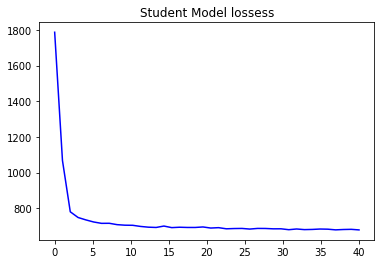

In [ ]:
plt.plot(np.linspace(0,len(epoch_loss_values)-80,len(epoch_loss_values)-80),epoch_loss_values[80:],color='blue')
#plt.plot(np.linspace(0,len(val_loss_values),len(val_loss_values)),val_loss_values,color='red')
plt.title('Student Model lossess')

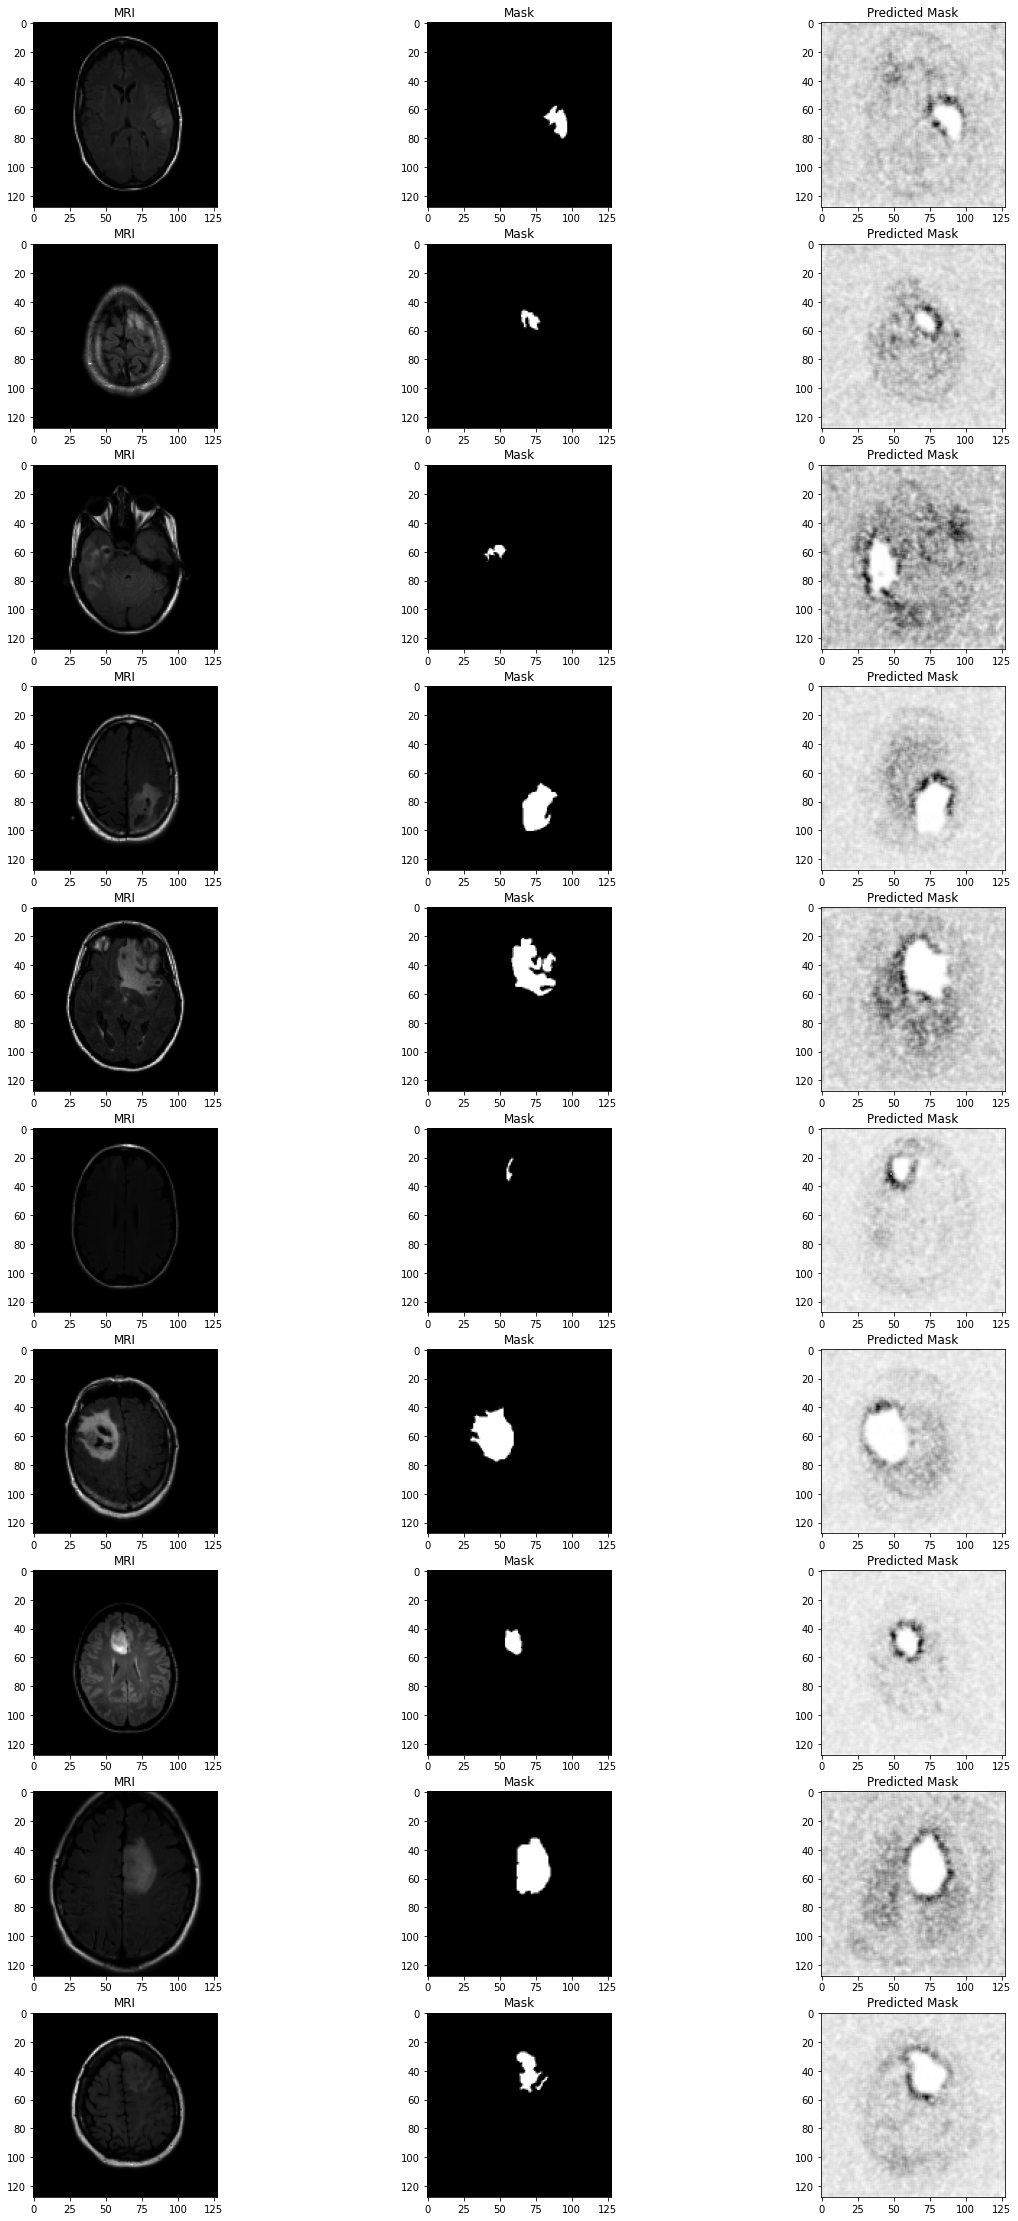

In [ ]:
r = 10
i=0
fig,ax = plt.subplots(r,3,figsize=(20,40))
for batch in val_loder:
    inp = torch.reshape(batch['img'],(1,1,128,128)).to(device)
    out = student_model(inp).to('cpu')
    ax[i,0].imshow(batch['img'][0,0,:,:],cmap='gray')
    ax[i,0].title.set_text('MRI')
    ax[i,1].imshow(batch['mask'][0,0,:,:],cmap='gray')
    ax[i,1].title.set_text('Mask')
    ax[i,2].imshow(out[0,0,:,:].detach().numpy().astype('uint8'),cmap='gray')
    ax[i,2].title.set_text('Predicted Mask')
    if i>=r-1:
        break
    i=i+1

### Visualizing the Results

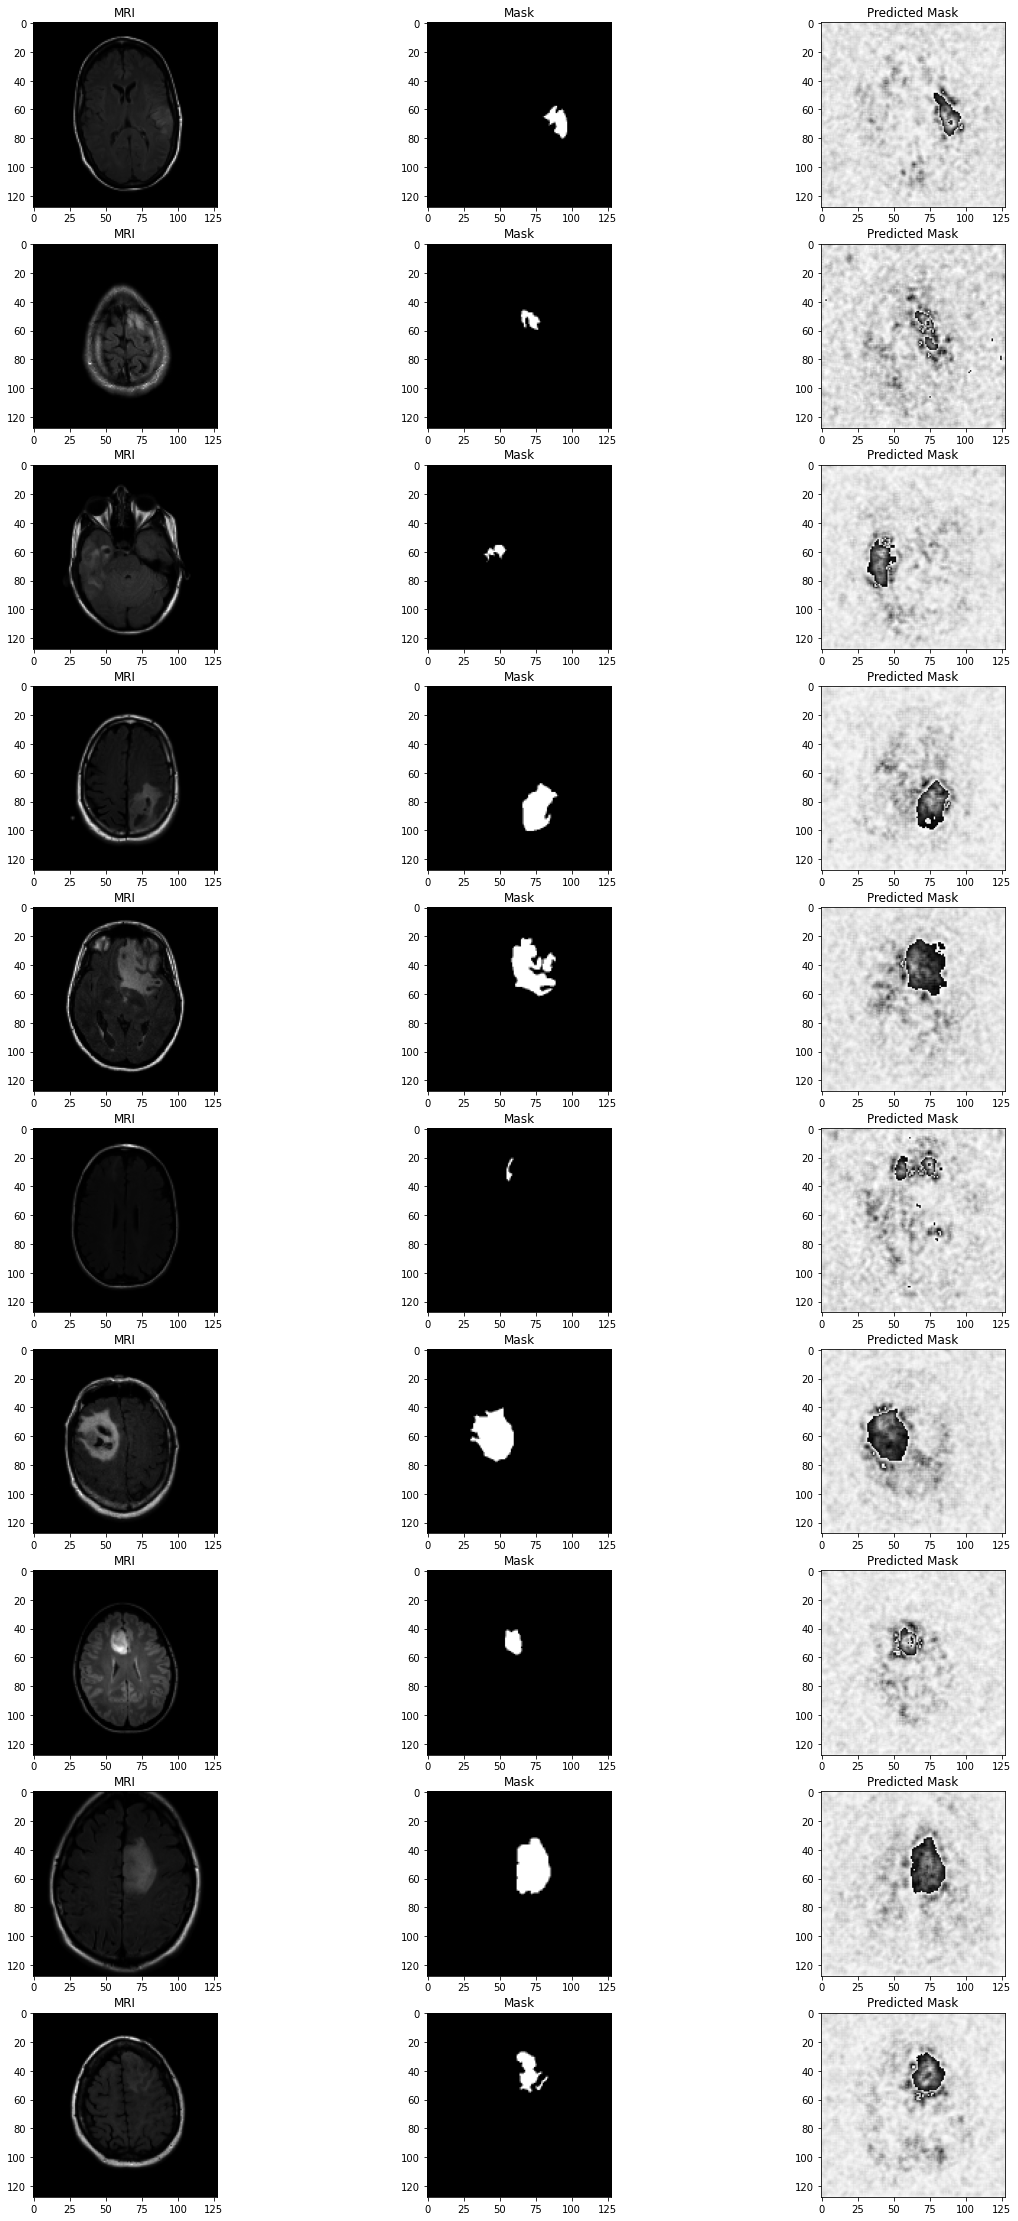

In [ ]:
r = 10
i=0
fig,ax = plt.subplots(r,3,figsize=(20,40))
for batch in val_loder:
    inp = torch.reshape(batch['img'],(1,1,128,128)).to(device)
    out = model(inp).to('cpu')
    ax[i,0].imshow(batch['img'][0,0,:,:],cmap='gray')
    ax[i,0].title.set_text('MRI')
    ax[i,1].imshow(batch['mask'][0,0,:,:],cmap='gray')
    ax[i,1].title.set_text('Mask')
    ax[i,2].imshow(out[0,0,:,:].detach().numpy().astype('uint8'),cmap='gray')
    ax[i,2].title.set_text('Predicted Mask')
    if i>=r-1:
        break
    i=i+1